In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitutils as ft
import scipy.optimize as opt
import fitutils as ft
import tools
import near0_nonlinear_acoustic
import near0_nonlinear_optic
import near0_integrated_analysis
import constants as cnt
import near0_quadra_nonlinear
import near0_linear_analysis
import schottky_analysis as sch
import polynomial_fit as pol
import debye_integration as db

### Ajustement par le modèle de Debye : prise en compte des modes acoustiques uniquement

$\frac{C}{T}(x = T²) = Cs(x) + \gamma + \beta x$, (en mJ/mol/K), avec $C_s(T) = $

Optimisation de la courbe $C/T(T²)$

Températures considérées : entre 0 et 20 K

#### Fit non lineaire direct 

Ajustement des données expérimentales à la fonction $\frac{C}{T}(x)$ = $\beta x$ + $\gamma$ + $Cs(x)$, en utilisant curve fit de scipy. 

Résultat visuellement peu satisfaisant entre 0 et 20 K, meilleur en restant à basse température (entre 0 et 10 K)

Beta, Gamma, n, E :  0.5975980634783241 8.616475379830913e-09 0.010175506175793127 9.000007077294152e-23


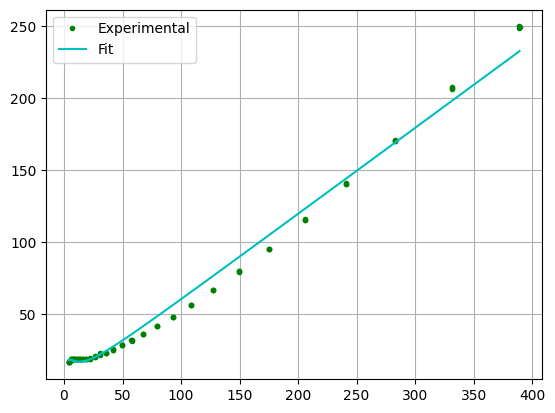

In [2]:
# Non linear fit between 0 K and 20 K

near0_nonlinear_acoustic.plot_fit_acoustic(0,400, cnt.squared_temperature, cnt.C_div_T, 
                                           cnt.err_sample_HC, bounds= ([0.1, 0, 1e-3, 9e-23],[1, 10, 5e-2, 1.2e-22]))

Beta, Gamma, n, E :  0.4858077222518549 1.5992556105939442 0.010999999999999302 1.1043272257500458e-22


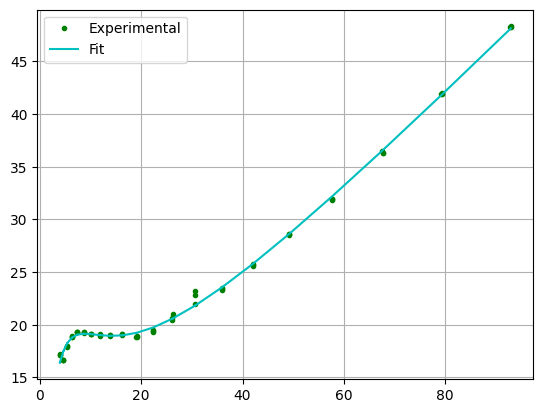

In [3]:
# Non linear fit between 0 K and 10 K

near0_nonlinear_acoustic.plot_fit_acoustic(0,100, cnt.squared_temperature, cnt.C_div_T, cnt.err_sample_HC)

#### Fit linéaire

Soustraction de la contribution de Schottky et ajustement avec une fonction linéaire selon le modèle $\frac{C}{T}(x)$ = $\beta x$ + $\gamma$. Pas de considération des modes optiques.

Les données sont ajustées avec la méthode des moindres carrés et de Monte Carlo pour les incertitudes. 

Pour T entre 0 et 20 K :

Les résultats donnent une pente $\beta = 0.4915 mJ//mol/K⁴$, soit une température de Debye de $371.8 K$, et une ordonnée à l'origine $\gamma = 1.68 mJ/K²/mol$

Pour T entre 0 et 10 K :

Les résultats donnent une pente $\beta = 0.4753 mJ//mol/K⁴$, soit une température de Debye de $376.01 K$, et une ordonnée à l'origine $\gamma = 1.83 mJ/K²/mol$

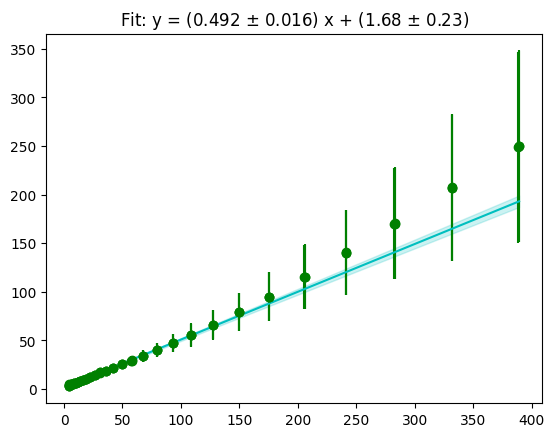

array([0.49157287, 1.67848106, 0.01557544, 0.23045388])

In [4]:
# Linear fit between 0 and 20 K

near0_linear_analysis.final(0, 400, cnt.E_optic, cnt.n_optic,cnt.temperature, cnt.squared_temperature, cnt.C_div_T)

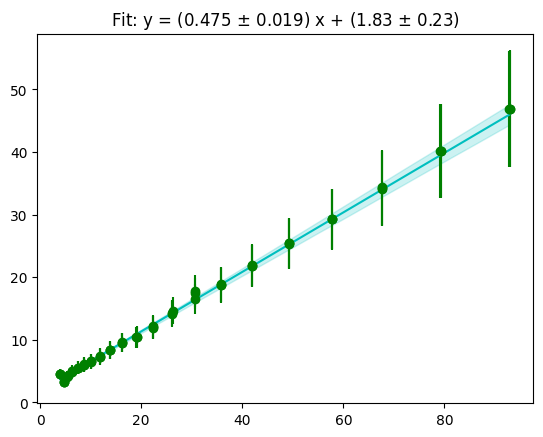

array([0.47539217, 1.83197079, 0.01890176, 0.22758811])

In [10]:
# Linear fit between 0 and 10 K

near0_linear_analysis.final(0, 100, cnt.E_optic, cnt.n_optic,cnt.temperature, cnt.squared_temperature, cnt.C_div_T)

### Prise en compte des modes optiques

Ajout d'une contribution en $x²$, modèle de Einstein

#### Fit polynomial

Soustraction de la contribution de Schottky et ajustement avec un polynôme de degré 2 afin de tenir compte des modes optiques. Ajustement par la méthode des moindres carrés et np.least_squares. 

Ajustement visuellement satisfaisant

Pour T entre 0 et 20 K :

Les résultats donnent une pente $\beta = 0.4463 mJ//mol/K⁴$, soit une température de Debye de $383.98 K$, et une ordonnée à l'origine $\gamma = 1.96 mJ/K²/mol$

Pour T entre 0 et 10 K :

Les résultats donnent une pente $\beta = 0.4693 mJ//mol/K⁴$, soit une température de Debye de $377.61 K$, et une ordonnée à l'origine $\gamma = 1.85 mJ/K²/mol$

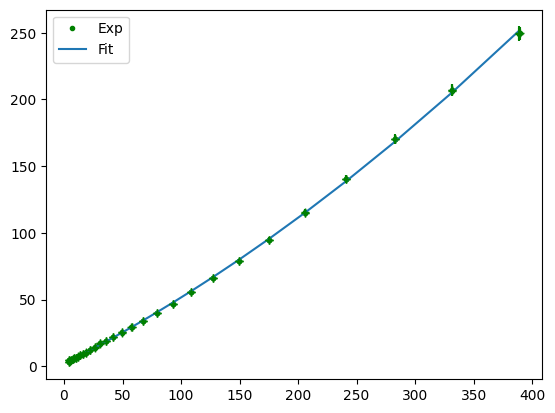

alpha, beta, gamma :  [5.02382725e-04 4.46338631e-01 1.96123651e+00]


In [5]:
# With  polyfit : deg=2, entre 0 et 20 K

print("alpha, beta, gamma : ", 
      pol.poly_fit(0, 20, cnt.temperature, cnt.squared_temperature, cnt.C_div_T, cnt.err_C_divT, cnt.E_optic, cnt.n_optic))


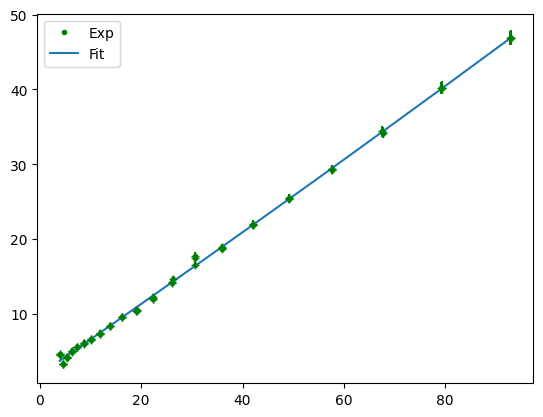

alpha, beta, gamma :  [1.63531906e-04 4.69363131e-01 1.85085393e+00]


In [11]:
# With  polyfit : deg=2, entre 0 et 10 K

print("alpha, beta, gamma : ", 
      pol.poly_fit(0, 10, cnt.temperature, cnt.squared_temperature, cnt.C_div_T, cnt.err_C_divT, cnt.E_optic, cnt.n_optic))

#### Fit non linéaire

Fit quadratique direct avec les valeurs entre 0 et 20 K, prise en compte de la contribution optique et de la contribution de Schottky. 

Utilisation de curve fit de scipy. 

Les valeurs obtenues sont similaires à celles obtenues avec l'ajustement polynomial. 

Pour T entre 0 et 20 K :

$\beta = 0.446 mJ/K⁴/mol$, $\gamma = 1.96 mJ/K⁴/mol$. La température de Debye associée est donc de $384.07 K$

Pour T entre 0 et 20 K :

$\beta = 0.437 mJ/K⁴/mol$, $\gamma = 3.28 mJ/K⁴/mol$. La température de Debye associée est donc de $386.69 K$


Beta, Gamma, n, E, nu :  0.44633863261624984 1.9612364149478514 0.010999999999999998 1.1183498428073282e-22 0.0005023827216230027


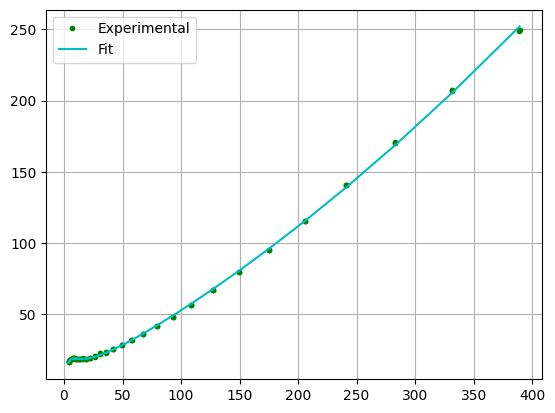

In [6]:
# Between 0 and 20 K

near0_nonlinear_optic.plot_fit_optic(0, 400, cnt.squared_temperature, cnt.C_div_T, cnt.err_C_divT,
                   bounds=([0.1, 0, 5e-3, 9.8e-23, 0], [1, 5, 1.1e-2, 1.2e-22, 1]))

Beta, Gamma, n, E, nu :  0.4374407116603595 3.2823984513293527 0.009904079856685542 1.109596291986181e-22 0.00036392415148370645


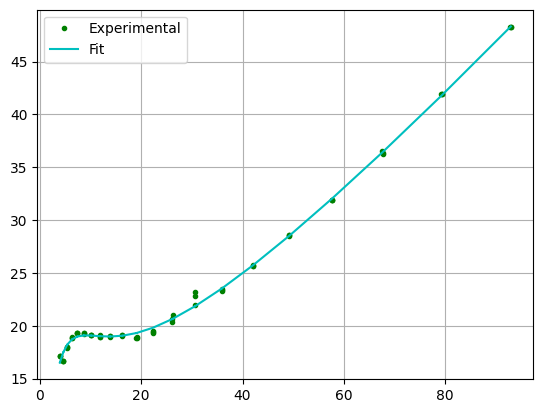

In [12]:
# Between 0 and 10 K

near0_nonlinear_optic.plot_fit_optic(0, 100, cnt.squared_temperature, cnt.C_div_T, cnt.err_C_divT,
                   bounds=([0.1, 0, 5e-3, 9.8e-23, 0], [1, 5, 1.1e-2, 1.2e-22, 1]))

### Ajustement directement avec l'intégrale de Debye

Données ajustées selon le modèle de Debye, mais sans approcher la valeur de l'intégrale de Debye par une constante. 

Résultats peu satisfaisants pour des températures supérieures à 12 K

#### Fit linéaire

Ajustement au modèle $\frac{C}{T}(x = T²) = \gamma + 9 n N_a k \frac{x}{\theta_D} I(y)$, avec $I(y) = \int \frac{y⁴ \exp(y)}{(\exp(y) - 1)²} dx$

Debye temperature, Gamma :  348.56595476588814 6.54164948602825e-17


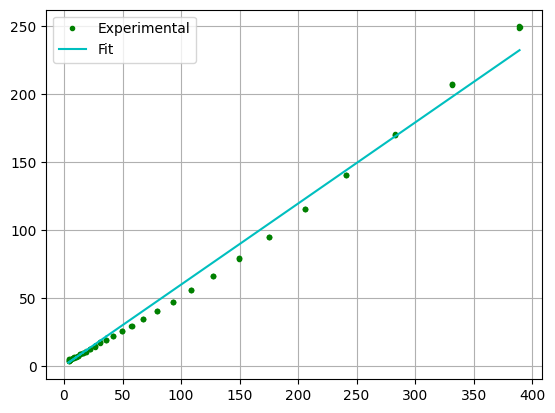

In [7]:
# Linear fit bewtween 0 and 20 K

temperature_bounded, err_bounded = tools.tab_interval(cnt.temperature, cnt.err_C_divT, 0, 20)
squared_temperature_bounded, C_div_T_bounded = tools.tab_interval(cnt.squared_temperature, cnt.C_div_T, 0, 400)
y_data = C_div_T_bounded - sch.schottky(temperature_bounded, cnt.E_optic, cnt.n_optic)/temperature_bounded

Td_1, gamma_1 = near0_integrated_analysis.fit_integrand_schottky_subtracted(0, 20, cnt.squared_temperature, cnt.temperature,
            cnt.C_div_T, cnt.E_curve_fit, cnt.n_curve_fit, p0=[300, 0], bounds=([300, 0], [500, 10]))[0]

print("Debye temperature, Gamma : ", Td_1, gamma_1)

plt.figure()
plt.plot(squared_temperature_bounded, y_data, ".g", label="Experimental")
plt.plot(squared_temperature_bounded, 
         near0_integrated_analysis.model_integrated_schottky_substracted(squared_temperature_bounded, Td_1, gamma_1), "c-", label="Fit")
plt.grid(True)
plt.legend()

Debye temperature, Gamma :  373.28340317748115 2.4342308682496077


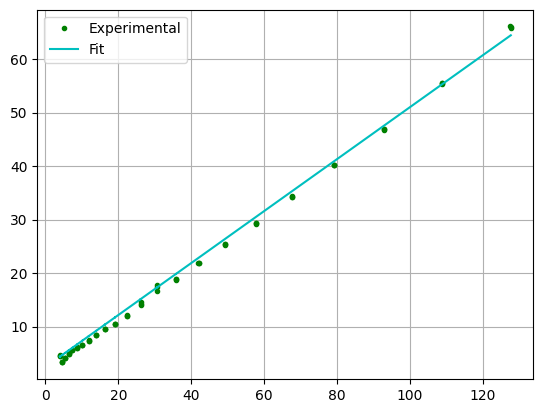

In [8]:
# Linear fit bewtween 0 and 12 K (Low temperature)

temperature_bounded, err_bounded = tools.tab_interval(cnt.temperature, cnt.err_C_divT, 0, 12)
squared_temperature_bounded, C_div_T_bounded = tools.tab_interval(cnt.squared_temperature, cnt.C_div_T, 0, 144)
y_data = C_div_T_bounded - sch.schottky(temperature_bounded, cnt.E_optic, cnt.n_optic)/temperature_bounded

Td_2, gamma_2 = near0_integrated_analysis.fit_integrand_schottky_subtracted(0, 12, cnt.squared_temperature, cnt.temperature,
            cnt.C_div_T, cnt.E_curve_fit, cnt.n_curve_fit, p0=[300, 0], bounds=([300, 0], [500, 10]))[0]

print("Debye temperature, Gamma : ", Td_2, gamma_2)

plt.figure()
plt.plot(squared_temperature_bounded, y_data, ".g", label="Experimental")
plt.plot(squared_temperature_bounded, 
         near0_integrated_analysis.model_integrated_schottky_substracted(squared_temperature_bounded, Td_2, gamma_2), "c-", label="Fit")
plt.grid(True)
plt.legend()

#### Non linear fit

Ajustement au modèle $\frac{C}{T}(x = T²) = \gamma + 9 n N_a k \frac{x}{\theta_D} I(y) + Cs(x)$ (Schottky contribution is not substracted)

Debye temperature, Gamma, E, n :  348.4692170214306 3.6693099070652514e-22 9.700000000797566e-23 0.010296511323891748


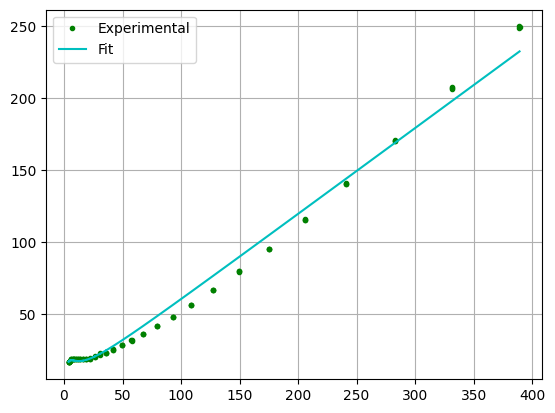

In [9]:

squared_temperature_bounded, C_div_T_bounded = tools.tab_interval(cnt.squared_temperature, cnt.C_div_T, 0, 400)

Td_3, gamma_3, E, n = near0_integrated_analysis.fit_integrand_schottky(0, 20, cnt.squared_temperature, cnt.C_div_T, 
                                    p0=[300, 0, 9.7e-23, 1e-3], bounds=([300, 0, 9.7e-23, 1e-3], [500, 10, 1.2e-22, 5e-2]))[0]

print("Debye temperature, Gamma, E, n : ", Td_3, gamma_3, E, n)

plt.figure()
plt.plot(squared_temperature_bounded, C_div_T_bounded, ".g", label="Experimental")
plt.plot(squared_temperature_bounded, 
         near0_integrated_analysis.model_integrated_schottky(squared_temperature_bounded, Td_3, gamma_3, E, n), "c-", label="Fit")
plt.grid(True)
plt.legend()